In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import randint
from sklearn.cluster import KMeans
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import train_test_split
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

In [44]:
bdif = pd.read_excel("bdif_modelo.xlsx")
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,detectadopor,fecha,combustible,fuego,lugar,...,velmedia,racha,sol,hrmedia,fwi,denpoblacion,denincendios,horario,areaquemada,claseincendio
0,1974020249,1974,11,2,0.0,otros,1974-04-25,bosques,sup_cop,otros,...,6.1,11.900000,9.5,56.0,12.101361,0.041339,0.000020,Tarde,8.0,incendio
1,1974020374,1974,11,2,0.0,otros,1974-05-19,bosques,sup_cop,excursionistas,...,6.4,13.100000,10.9,53.0,69.039001,0.334612,0.000013,Tarde,0.3,conato
2,1974020459,1974,11,46,0.0,agente_forestal,1974-06-11,bosques,sup_cop,otros,...,3.6,11.100000,3.3,71.0,11.837668,0.084859,0.000022,Mañana,0.6,conato
3,1974022274,1974,11,2,0.0,otros,1974-09-11,bosques,sup_cop,autovia_carretera,...,5.0,7.116667,8.9,63.0,42.358257,0.139880,0.000123,Tarde,2.0,incendio
4,1974022457,1974,11,2,0.0,agente_forestal,1974-10-01,mat_bos,sup_cop,otros,...,4.7,14.400000,9.3,45.0,15.454229,0.035034,0.000068,Mañana,0.5,conato


### Normalizamos variables numéricas

In [45]:
# Seleccionamos las variables numéricas
numericas = ['probignicion', 'altitud', 'lon', 'lat', 'prec', 'tmax', 'dir', 'velmedia',
             'racha', 'sol', 'hrmedia', 'denpoblacion', 'denincendios', 'fwi']

# Cargamos el Standard Scaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

bdif[numericas] = scaler.fit_transform(bdif[numericas])

# Mostramos el resultado
bdif[numericas].head()

,probignicion,altitud,lon,lat,prec,tmax,dir,velmedia,racha,sol,hrmedia,denpoblacion,denincendios,fwi
0,0.0,0.517710,0.703490,0.663822,0.0,0.462795,0.805556,0.194268,0.218750,0.637584,0.541667,0.000166,0.000014,0.068724
1,0.0,0.335891,0.731106,0.672918,0.0,0.637024,0.500000,0.203822,0.240809,0.731544,0.510417,0.001347,0.000006,0.421203
2,0.0,0.351240,0.760152,0.707177,0.0,0.571688,0.250000,0.114650,0.204044,0.221477,0.697917,0.000341,0.000018,0.067092
3,0.0,0.664109,0.699029,0.672143,0.0,0.662432,0.418981,0.159236,0.130821,0.597315,0.614583,0.000563,0.000145,0.256033
4,0.0,0.410272,0.714636,0.675420,0.0,0.575318,0.694444,0.149682,0.264706,0.624161,0.427083,0.000141,0.000076,0.089480


### One Hot Encoding variables categóricas

In [46]:
# Lista de columnas categóricas
categoricas = ['detectadopor', 'combustible', 'fuego', 'lugar', 'mes', 'dia', 'horario']

# Generar variables dummies y agregarlas directamente al DataFrame
bdif = pd.get_dummies(bdif, columns=categoricas, drop_first=False)

# Seleccionar las columnas dummies y convertirlas a 0 y 1
dummies = bdif.filter(regex='^detectadopor|^combustible|^fuego|^lugar|^mes|^dia|^horario').columns

# Convertir solo esas columnas a 0 y 1
bdif[dummies] = bdif[dummies].astype(int)

# Mostramos el resultado
bdif.head()

,parte,año,cod_com,cod_prov,probignicion,fecha,poblacion,superficie,altitud,lon,...,mes_octubre,mes_septiembre,dia_festivo,dia_lab_vis_fes,dia_laborable,dia_sabado,horario_Madrugada,horario_Mañana,horario_Noche,horario_Tarde
0,1974020249,1974,11,2,0.0,1974-04-25,2117.457786,51221.68,0.517710,0.703490,...,0,0,0,0,1,0,0,0,0,1
1,1974020374,1974,11,2,0.0,1974-05-19,26076.005568,77929.12,0.335891,0.731106,...,0,0,1,0,0,0,0,0,0,1
2,1974020459,1974,11,46,0.0,1974-06-11,3790.498405,44668.00,0.351240,0.760152,...,0,0,0,0,1,0,0,1,0,0
3,1974022274,1974,11,2,0.0,1974-09-11,1133.070631,8100.28,0.664109,0.699029,...,0,1,0,0,1,0,0,0,0,1
4,1974022457,1974,11,2,0.0,1974-10-01,513.556146,14658.96,0.410272,0.714636,...,1,0,0,0,1,0,0,1,0,0


### Etiquetas numéricas para la variable objetivo

In [10]:
# Crear un diccionario para mapear las clases a valores específicos
mapeo_clases = {'conato': 0, 'incendio': 1, 'gif': 2}

# Aplicar el mapeo a la columna 'claseincendio'
bdif['claseincendio'] = bdif['claseincendio'].map(mapeo_clases)

# Verificar el resultado
print(bdif['claseincendio'].value_counts())

claseincendio
0    334211
1    234195
2      1966
Name: count, dtype: int64


In [11]:
bidf_save = bdif.copy()

In [12]:
# Tomamos el dataset con las caracteristicas que nos interesan
bdif = bdif[['denincendios', 'tmax', 'denpoblacion', 'lon', 'lat', 'fuego_sup_cop', 'fwi', 'hrmedia', 'altitud',
          'fuego_superficie', 'sol', 'racha', 'dir', 'velmedia', 'probignicion', 'combustible_matorrales',
          'combustible_mat_bos', 'prec', 'combustible_pas_mat_bos', 'detectadopor_agente_forestal', 'horario_Noche',
          'horario_Tarde', 'lugar_otros', 'detectadopor_vigilante_fijo', 'dia_laborable', 'mes_agosto',
          'detectadopor_llamada_particular', 'lugar_autovia_carretera', 'lugar_senda', 'detectadopor_otros', 'dia_festivo',
          'mes_septiembre', 'combustible_pastizales', 'dia_sabado', 'combustible_bosques', 'horario_Mañana', 'claseincendio']]

### Submuestreo Cluster-Based

In [13]:
# Dividir las clases mayoritarias y minoritaria
conatos = bdif[bdif['claseincendio'] == 0]
incendios = bdif[bdif['claseincendio'] == 1]
gif = bdif[bdif['claseincendio'] == 2]

start_time = time.time()

def cluster_based(df, muestras):
    """
    Submuestreo para balancear las clases mayoritarias en base a clústeres.
    
    Párametros:
        df (pd.DataFrame): DataFrame con la clase mayoritaria.
        muestras (int): Número objetivo de muestras para la clase mayoritaria.

    Returns:
        pd.DataFrame: DataFrame submuestreado.
    """
  
    # Creamos clústeres con KMeans
    kmeans = KMeans(n_clusters=muestras, random_state=42)
    df.loc[:, 'cluster'] = kmeans.fit_predict(df.drop(columns=['claseincendio']))
    
    # Muestra representativa
    df_cluster = (df.groupby('cluster', observed=True).apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True))
    
    # Eliminar la columna auxiliar creada para guardar el cluster
    df_cluster = df_cluster.drop(columns=['cluster'])
    
    return df_cluster

conatos_sub = cluster_based(conatos, len(gif))
incendios_sub = cluster_based(incendios, len(gif))

# Combinar todas las clases
bdif_cluster = pd.concat([conatos_sub, incendios_sub, gif])

# Verificar el equilibrio
print(bdif_cluster['claseincendio'].value_counts())

end_time = time.time()
print(f"El submuestreo tardó {end_time - start_time} segundos.")

claseincendio
0    3000
1    3000
2    1966
Name: count, dtype: int64
El submuestreo tardó 355.0783772468567 segundos.


### Tomek Links

In [14]:
start_time = time.time()

X = bdif.drop(['claseincendio'], axis=1)
y = bdif['claseincendio'] 

tomek = TomekLinks(sampling_strategy='auto')
X_resampled, y_resampled = tomek.fit_resample(X, y)

# Creamos el dataframe
bdif_tomek= pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['claseincendio'])], axis=1)
end_time = time.time()
print(f"El submuestreo tardó {end_time - start_time} segundos.")

# Mostramos el balanceo
print(bdif_tomek['claseincendio'].value_counts())

El submuestreo tardó 524.7001042366028 segundos.
claseincendio
0    288570
1    188155
2      1966
Name: count, dtype: int64


### Edited Nearest Neighbors (ENN)

In [26]:
start_time = time.time()

# Creamos una función para aplicar submuestreo
def submuestrear_enn(df, clase):
    """
    Submuestreo de las clases mayoritarias meidante Edited Nearest Neighbors (ENN)
    
    Parametros:
        df (DataFrame): dataset al que queremos realizar el submuestreo
        clase (str): nombre de la columna de la variable objetivo

    Retorna:
        df_sub (DataFrame): dataframe después de haber aplicado ENN
    """
    # Separamos variables descriptivas de la variable objetivo
    X = df.drop(columns=[clase])
    y = df[clase]
    
    # Configurar ENN
    enn = EditedNearestNeighbours(n_neighbors=5, kind_sel='all')
    
    # Aplicar ENN
    X_sub, y_sub = enn.fit_resample(X, y)
    
    # Reconstruir el DataFrame con los datos resampleados
    df_sub = pd.DataFrame(X_sub, columns=X.columns)
    df_sub[clase] = y_sub
    
    return df_sub

# le pasamos la funcion a los conatos e incendios
bdif_enn = submuestrear_enn(bdif, clase='claseincendio')


# Mostramos como ha quedado el muestreo
print(bdif_enn['claseincendio'].value_counts())

end_time = time.time()
print(f"El submuestreo tardó {end_time - start_time} segundos.")

claseincendio
0    70626
1    26405
2     1966
Name: count, dtype: int64
El submuestreo tardó 517.9509210586548 segundos.


### ENN + Tomek Links

In [34]:
start_time = time.time()

X = bdif_enn.drop(['claseincendio'], axis=1)
y = bdif_enn['claseincendio'] 

tomek = TomekLinks(sampling_strategy='auto')
X_resampled, y_resampled = tomek.fit_resample(X, y)

# Creamos el dataframe
bdif_enn_tomek= pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['claseincendio'])], axis=1)
end_time = time.time()
print(f"El submuestreo tardó {end_time - start_time} segundos.")

# Mostramos el balanceo
print(bdif_enn_tomek['claseincendio'].value_counts())

El submuestreo tardó 14.055110454559326 segundos.
claseincendio
0    70482
1    26177
2     1966
Name: count, dtype: int64


In [48]:
bdif_enn_tomek.to_excel("bdif_submuestreado.xlsx", index=False)

### Función reducción de muestras

In [68]:
X = bdif_enn_tomek.drop(['claseincendio'], axis=1)
y = bdif_enn_tomek['claseincendio']

rus = RandomUnderSampler(sampling_strategy={0: int(2*y.value_counts()[2]), 1: int(2.5*y.value_counts()[2])}, random_state=42)
#rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_res, y_res = rus.fit_resample(X, y)

bdif_sub = pd.concat([X_res, y_res], axis=1)
print(bdif_sub['claseincendio'].value_counts())

claseincendio
1    4915
0    3932
2    1966
Name: count, dtype: int64


### Random Forest

In [64]:
# Para probar el dataset solo aplicando el submuestreo y sin balancear las clases
X = bdif_sub.drop(['claseincendio'], axis=1)
y = bdif_sub['claseincendio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
# Entrenar el modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
# Hacemos las predicciones
y_pred = rf.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       791
           1       0.84      0.86      0.85      1008
           2       0.67      0.59      0.63       364

    accuracy                           0.84      2163
   macro avg       0.81      0.80      0.80      2163
weighted avg       0.84      0.84      0.84      2163



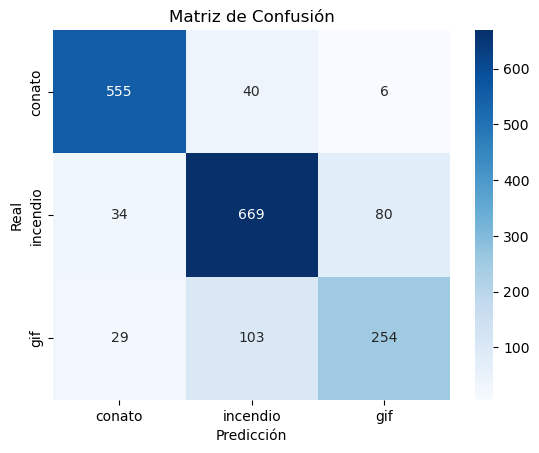

In [57]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Guardamos las etiquetas reales
etiquetas= ['conato', 'incendio', 'gif']

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

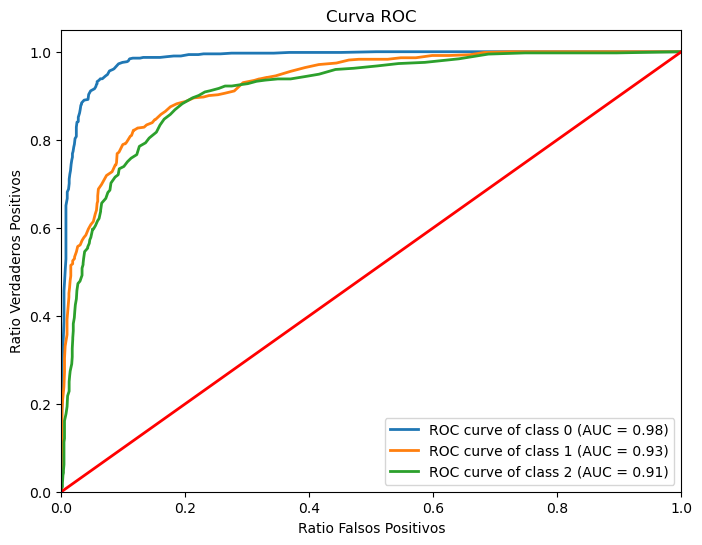

In [32]:
y_pred_prob = rf.predict_proba(X_test)

# Binarizamos porque es una clasificación multiclase
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Inicializamos las variables para calcular la curva roc y el auc
fpr = {}
tpr = {}
roc_auc = {}

# Dibujamos una curva ROC por cada clase y el calculo del auc
for i in range(3):  
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])  

# Dibujar las curvas 
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

# Creamos la diagonal
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='-')

# Configurar el gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')

# Mostrar el gráfico
plt.show()